In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [3]:
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'], errors='coerce')
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')

# Drop rows with invalid dates
customers_df.dropna(subset=['SignupDate'], inplace=True)
transactions_df.dropna(subset=['TransactionDate'], inplace=True)

# Calculate customer metrics
customer_metrics = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Number of transactions
    'TotalValue': ['sum', 'mean'],  # Total and average purchase value
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()

customer_metrics.columns = ['CustomerID', 'transaction_count', 'total_spend', 'avg_purchase_value', 'total_quantity']

# Calculate days since signup
reference_date = pd.Timestamp.now()
customers_df['days_since_signup'] = (reference_date - customers_df['SignupDate']).dt.days

# Merge customer metrics with profile data
customer_features = customers_df.merge(customer_metrics, on='CustomerID', how='left')

# Convert region to numeric using one-hot encoding
region_dummies = pd.get_dummies(customer_features['Region'], prefix='region')
customer_features = pd.concat([customer_features, region_dummies], axis=1)

# Select features for clustering
features_for_clustering = [
    'days_since_signup', 'transaction_count', 'total_spend', 
    'avg_purchase_value', 'total_quantity'
]

In [4]:
X = customer_features[features_for_clustering].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try different numbers of clusters and calculate DB Index
n_clusters_range = range(2, 11)
db_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    db_score = davies_bouldin_score(X_scaled, cluster_labels)
    db_scores.append(db_score)

# Find optimal number of clusters (minimum DB Index)
optimal_clusters = n_clusters_range[np.argmin(db_scores)]

# Perform final clustering with optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(X_scaled)

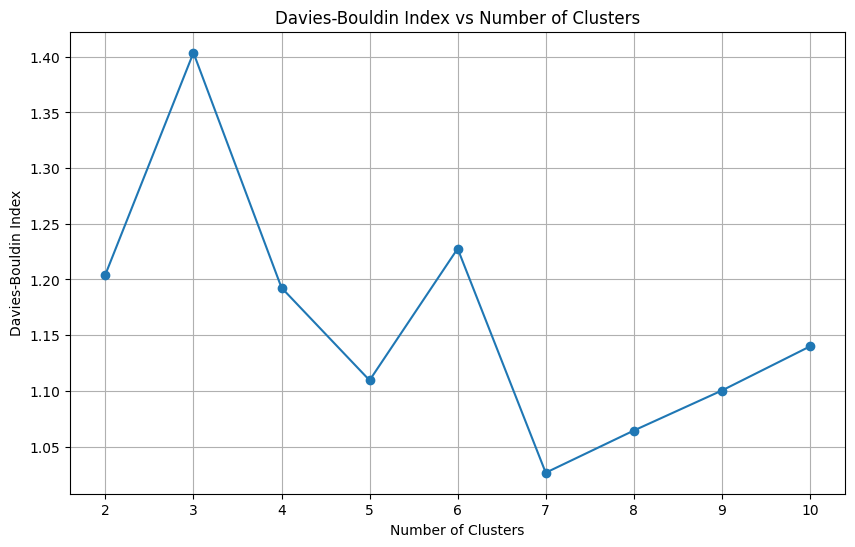

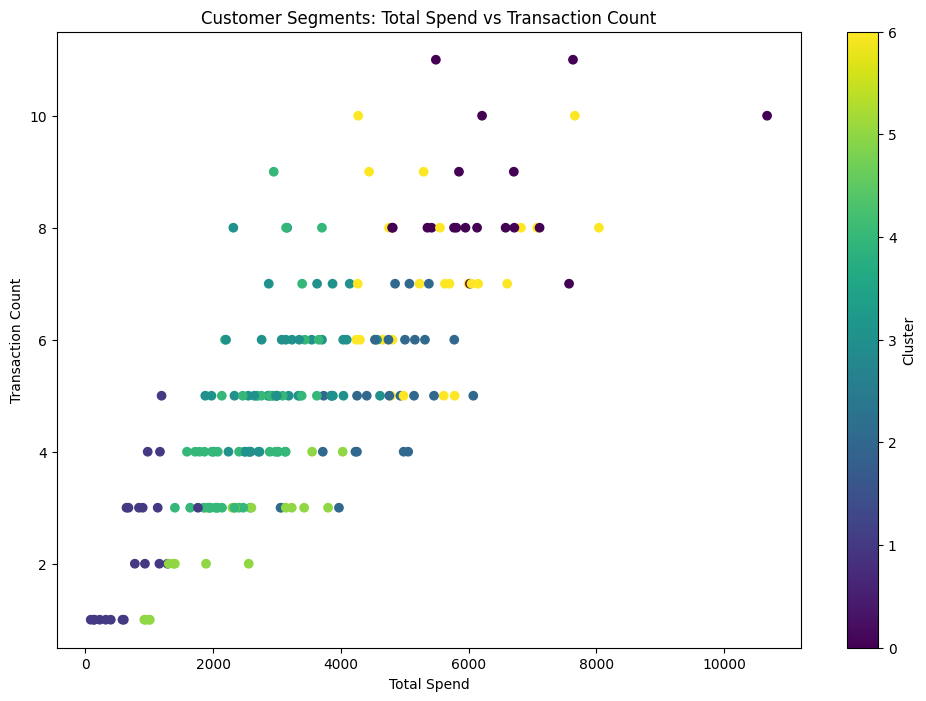

In [5]:
# Plot DB Index scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)
plt.show()

# Visualize clusters using total spend vs transaction count
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    customer_features['total_spend'],
    customer_features['transaction_count'],
    c=customer_features['Cluster'],
    cmap='viridis'
)
plt.xlabel('Total Spend')
plt.ylabel('Transaction Count')
plt.title('Customer Segments: Total Spend vs Transaction Count')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [6]:
cluster_profiles = customer_features.groupby('Cluster').agg({
    'days_since_signup': 'mean',
    'transaction_count': 'mean',
    'total_spend': 'mean',
    'avg_purchase_value': 'mean',
    'total_quantity': 'mean'
}).round(2)

print("\nOptimal number of clusters:", optimal_clusters)
print("\nDavies-Bouldin Index:", min(db_scores))
print("\nCluster Profiles:")
print(cluster_profiles)


Optimal number of clusters: 7

Davies-Bouldin Index: 1.026525166896035

Cluster Profiles:
         days_since_signup  transaction_count  total_spend  \
Cluster                                                      
0                   860.84               8.53      6348.17   
1                   546.45               2.24       756.93   
2                   791.12               5.12      4743.41   
3                   292.93               5.37      3101.28   
4                   882.50               4.43      2550.37   
5                   253.00               2.45      2287.42   
6                   227.42               7.08      5508.56   

         avg_purchase_value  total_quantity  
Cluster                                      
0                    751.36           23.42  
1                    347.67            4.10  
2                    955.19           14.54  
3                    588.79           12.42  
4                    599.61           10.35  
5                    930.89 